In [1]:
!pip install -Uqq fastbook kaggle waterfallcharts treeinterpreter dtreeviz
import fastbook
fastbook.setup_book()


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mxnet-cu110 1.9.1 requires graphviz<0.9.0,>=0.8.1, but you have graphviz 0.20.1 which is incompatible.


In [2]:
from fastbook import *
from pandas.api.types import is_string_dtype, is_numeric_dtype,is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *

from IPython.display import Image, display_svg, SVG


pd.options.display.max_rows=20
pd.options.display.max_columns = 8

for Tabular data, we will have both numerical and categorical data - numerical data can be fed directly with some pre-processing, but categorical data like "sex" should be converted to numerical form before feeding to DL or ML libraries

there is a embedding layer used by nns to encode categorical variables. Typically, these are combinations of a linear layer and one-hot encoding layer. Upon analysis, the embedding is found to transform the categorical variable into continuous and meaningful variable.


Most deep learning algorithms are good at working with unstructured complex data like image recognition, speech processing , nlp etc. Deep learning could also be used for structured data like collaborative filtering and tabular data, but similar results could be achieved with Ml algo with less processing time and without GPU.

There are many ML algos but usually many problems can be solved with Decision Trees and Random Forests and other Ensemble methods like Boost.

the tree based methods help interpret the data well compared to other techniques. Like which column has the most influence on the output, how are they related etc

Ensembles of decision trees are the go to ML algo for tabular data analysis except for the following conditions:
a. There are high-cardinatlity categorical variables : more levels (e.g zip code , there could be thousands)
b. Presence of some columns which could be dealt with neural networks - plain text data

Pytorch+fastai - useful for parallelization of matrix multiplication operations, not quite useful for Ml algorithms.
sklearn - has a good collection of machine learning algorithms along with  pandas and numpy for array operations.

In [3]:
path = Path('/kaggle/input/bluebook-for-bulldozers')

In [4]:
path.ls()


(#14) [Path('/kaggle/input/bluebook-for-bulldozers/Valid.7z'),Path('/kaggle/input/bluebook-for-bulldozers/Valid.zip'),Path('/kaggle/input/bluebook-for-bulldozers/Train.zip'),Path('/kaggle/input/bluebook-for-bulldozers/TrainAndValid.csv'),Path('/kaggle/input/bluebook-for-bulldozers/median_benchmark.csv'),Path('/kaggle/input/bluebook-for-bulldozers/Valid.csv'),Path('/kaggle/input/bluebook-for-bulldozers/Machine_Appendix.csv'),Path('/kaggle/input/bluebook-for-bulldozers/random_forest_benchmark_test.csv'),Path('/kaggle/input/bluebook-for-bulldozers/Data Dictionary.xlsx'),Path('/kaggle/input/bluebook-for-bulldozers/ValidSolution.csv')...]

In [5]:
path

Path('/kaggle/input/bluebook-for-bulldozers')

In [6]:
df = pd.read_csv(path/'TrainAndValid.csv', low_memory=False)

In [7]:
df.head()

,SalesID,SalePrice,MachineID,ModelID,...,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,...,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,...,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,...,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,...,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,...,NaN,NaN,NaN,NaN


In [8]:
df.columns


Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'saledate', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc',
       'fiModelSeries', 'fiModelDescriptor', 'ProductSize',
       'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc',
       'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
       'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
       'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
       'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size',
       'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type',
       'Travel_Controls', 'Differential_Type', 'Steering_Controls'],
      dtype='object')

In [9]:
df['ProductSize'].unique()

array([nan, 'Medium', 'Small', 'Large / Medium', 'Mini', 'Large', 'Compact'], dtype=object)

In [10]:
sizes = 'Large','Large / Medium','Medium','Small','Mini','Compact'

In [11]:

df['ProductSize'] = df['ProductSize'].astype('category')

In [12]:
df['ProductSize'].cat.set_categories(sizes,ordered=True,inplace=True)

/opt/conda/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.


In [13]:
df['ProductSize'].head()

0       NaN
1    Medium
2       NaN
3     Small
4       NaN
Name: ProductSize, dtype: category
Categories (6, object): ['Large' < 'Large / Medium' < 'Medium' < 'Small' < 'Mini' < 'Compact']

In the Kaggle competition, the metric to be used is Mean Squared Log Error . This is to be minimized.


Decision Trees : Solving the problem with the help of decision trees, which are effective for tabular data.

The trees work well with categorical data and cardinal values. But, another important feature is the date - But it neither falls in the cardinal nor categorical feature. So, fastai library converts the date column into a few categorical features.

In [14]:
df = add_datepart(df,'saledate')

In [15]:
df.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc', 'fiModelSeries',
       'fiModelDescriptor', 'ProductSize', 'fiProductClassDesc', 'state',
       'ProductGroup', 'ProductGroupDesc', 'Drive_System', 'Enclosure',
       'Forks', 'Pad_Type', 'Ride_Control', 'Stick', 'Transmission',
       'Turbocharged', 'Blade_Extension', 'Blade_Width', 'Enclosure_Type',
       'Engine_Horsepower', 'Hydraulics', 'Pushblock', 'Ripper', 'Scarifier',
       'Tip_Control', 'Tire_Size', 'Coupler', 'Coupler_System',
       'Grouser_Tracks', 'Hydraulics_Flow', 'Track_Type',
       'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb', 'Pattern_Changer',
       'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type', 'Travel_Controls',
       'Differential_Type', 'Steering_Controls', 'saleYear', 'saleMonth',
       'saleWeek', 'saleDay', 'saleDayofweek', 'saleDayofyear',


In [16]:
df_test = pd.read_csv(path/'Test.csv', low_memory=False)
df_test = add_datepart(df_test, 'saledate')

In [17]:
' '.join(o for o in df.columns if o.startswith('sale'))

'saleYear saleMonth saleWeek saleDay saleDayofweek saleDayofyear saleIs_month_end saleIs_month_start saleIs_quarter_end saleIs_quarter_start saleIs_year_end saleIs_year_start saleElapsed'

Using Fastai's TabularPandas and TabularProcs tools to process missing values and categorical features in Pandas dataframe.

In [18]:
procs = [Categorify, FillMissing]

In [19]:
cond =(df.saleYear < 2011) | (df.saleMonth < 10)
train_idx = np.where(cond)[0]
valid_idx = np.where(~cond)[0]

In [20]:
splits = (list(train_idx), list(valid_idx))

In [21]:
dep_var = 'SalePrice'
df[dep_var] = np.log(df[dep_var])

In [22]:
cont,cat = cont_cat_split(df,1,dep_var = dep_var)

In [23]:
to = TabularPandas(df, procs,cat,cont,y_names=dep_var,splits=splits)

In [24]:
len(to.train), len(to.valid)

(404710, 7988)

In [25]:
to.show(3)

,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,auctioneerID_na,MachineHoursCurrentMeter_na,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,saleYear,saleMonth,saleWeek,saleDay,saleDayofweek,saleDayofyear,saleElapsed,SalePrice
0,Low,521D,521,D,#na#,#na#,#na#,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,False,False,1139246,999089,3157,121,3.0,2004,68.0,2006,11,46,16,3,320,1.163635e+09,11.097410
1,Low,950FII,950,F,II,#na#,Medium,Wheel Loader - 150.0 to 175.0 Horsepower,North Carolina,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,23.5,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,False,False,1139248,117657,77,121,3.0,1996,4640.0,2004,3,13,26,4,86,1.080259e+09,10.950807
2,High,226,226,#na#,#na#,#na#,#na#,Skid Steer Loader - 1351.0 to 1601.0 Lb Operating Capacity,New York,SSL,Skid Steer Loaders,#na#,OROPS,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Auxiliary,#na#,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,None or Unspecified,Standard,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,False,False,False,False,False,False,False,False,1139249,434808,7009,121,3.0,2001,2838.0,2004,2,9,26,3,57,1.077754e+09,9.210340


In [26]:
to.classes['ProductSize']

['#na#', 'Large', 'Large / Medium', 'Medium', 'Small', 'Mini', 'Compact']

A good practice is save the data which has been processed, so that in case of disconnetivity, the saved data could be used to work further

In [27]:
save_pickle('/kaggle/working/to.pkl',to)

In [28]:
X,y = to.train.xs, to.train.y
valid_X, valid_y = to.valid.xs, to.valid.y

In [29]:
m = DecisionTreeRegressor(max_leaf_nodes=4)
m.fit(X,y)

DecisionTreeRegressor(max_leaf_nodes=4)

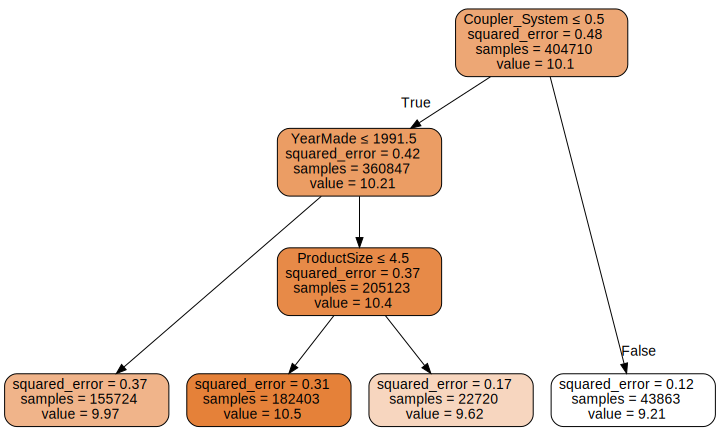

In [30]:
draw_tree(m, X, size=10,leaves_parallel=True, precision=2)

In [31]:
len(y)

404710

There is a powerful tree visualization library called dtreeviz which helps to understand the decision taken by trees well.

This time, a a bigger tree is built to check the accuracy of the decision tree for regression problem. This is achieved by the letting the DecisionTree Regressor choose the max_leaf_nodes

In [32]:
m = DecisionTreeRegressor()
m.fit(X,y)

DecisionTreeRegressor()

In [33]:
def r_mse(pred,y) : return round(math.sqrt(((pred-y)**2).mean()),6)
def m_rmse(m,X,y) : return r_mse(m.predict(X),y)

In [34]:
m_rmse(m,X,y)

0.0

On the training set, the root mean squared is reduced to zero, which seems fantastic, but to reaffirm the performance, we need to test it on validation set

In [35]:
m_rmse(m, valid_X,valid_y)

0.329487

There is a method to get the number of leaves.

In [36]:
m.get_n_leaves(), len(X)

(324583, 404710)

The Decision Tree has used a whopping 324591 leaves for a sample of size 404710. It is thus no surprise that it is able to completely fit the data to zero error, but generalizes poorly to validation data set.

The sklearn.tree library continues splitting the dataset into multiple leaf nodes till there is one data point in every leaf. this could be prevented by setting minimum of datapoints to be present in each node.

In [37]:
m = DecisionTreeRegressor(min_samples_leaf = 25)
m.fit(X,y)
m_rmse(m,X,y)

0.211677

In [38]:
m.get_n_leaves()

12397

In [39]:
m_rmse(m,valid_X,valid_y)

0.268005

Tree is a beatiful algorithm which handles non-linearity and complex relationships between features well, but a small tree generalizes well on validation data while a large tree reduces training error to zero. A trick to get the best of both is needed.

For neural networks, we use One-hot Encoding and then the Embedding layer processes this categoricalvariable one-hot encoded. but, there is no evidence that this improves performance of DTs. In fact it increases the number of features and thus the time-complexity of the DTs.

Random forests : an improvement over the Decision Trees

The idea is that, we bootstrap the training dataset - sample a sub set of the data, train it using a model and save it. This way, we get a lot of models and we make predictions using these models on validation dataset and take average of all the prediction .This is based on a deep insight. Individually these models would have larger error than those with large dataset at disposal.but, these models generated different kinds of errors and they would all average out to make the average prediction move closer to the actual value.


Random forest goes a step further, it also chooses a set of columns in random to increase the variety.

In [40]:
def rf(X,y,n_estimators=80,max_samples=100000,max_features=0.7,min_samples_leaf=5,**kwargs):
    return RandomForestRegressor(n_jobs=-1,n_estimators=n_estimators,max_samples=max_samples,max_features=max_features,min_samples_leaf=min_samples_leaf,oob_score=True).fit(X,y)

In [41]:
m = rf(X,y)

In [42]:
m_rmse(m,X,y), m_rmse(m,valid_X,valid_y)

(0.192085, 0.237648)

An important feature of Random Forests is that it is very sensitive to hyperparameter choices - setting n_estimators to high value tends to increase the accuracy,but also increases training time. Also, min_samples_leaf = 5 is a good choice with max_features=0.5

In [43]:
preds = np.stack([t.predict(valid_X) for t in m.estimators_])

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has fea

In [44]:
r_mse(preds.mean(0), valid_y)

0.237648

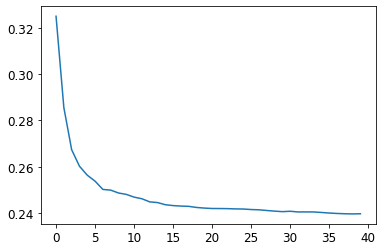

In [45]:

plt.plot([r_mse(preds[:i+1].mean(0), valid_y) for i in range(40)]);

the error on validation set is still worse. it could be due to two reasons : Overfitting or the validation set belongs to a different time period.

Random forest has a tool called Out of Bag error to find out the reason.

The intuition behind the OOB error is that , every tree trained in RF algo is trained on a subset of the entire dataset and not on the complete dataset. This means that the rows which were not trained on the tree become the validation set of the particular tree. So, a separate validation dataset is not required.



In [46]:
r_mse(m.oob_prediction_, y)

0.216627

This value is lower than the 0.24 we got before , implying there could be some other reason other than overfitting .

Model interpretation is a very important step to be done for tabular data analysis.

This could be computed for Random forests using the variance of the trees. Along with the mean, we also get the standard deviation of the tree predictions. if the std is more, less the confidence and if std is low, consistent predictions.

It is important to get the prediction confidence to gauge the model's prediction.Getting the prediction from the model is one thing but to know how confident it is of the prediction is another important thing. 

In [47]:
preds = np.stack([t.predict(valid_X) for t in m.estimators_])

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has fea

In [48]:
preds.shape

(80, 7988)

In [49]:
preds_std = preds.std(0)

In [50]:
preds_std.shape

(7988,)

Shape interpretation : 80 here corresponds to the number of trees, and 7988 corresponds to the number of rows in the validation set. standard deviation is computed for each row across all the trees.

In [51]:
preds_std[:5]

array([0.27865999, 0.11052207, 0.10416634, 0.27402153, 0.14485194])

there is a large variance for some rows while less for other rows.

It is also important to know which columns contribute better to predictions and which don't. It forms an important model interpretability parameter.

Feature importance : The features which are the most important should be sorted out from those which dont contribute much. RandomforestRegressor of sklearn helps separate out the good features from the rest!


In [52]:
type(valid_X)

pandas.core.frame.DataFrame

In [53]:
def rf_feat_importance(m,df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}).sort_values('imp',ascending=False)


In [54]:
features_imp = rf_feat_importance(m,X)


In [55]:
features_imp[:10]

,cols,imp
57,YearMade,0.185734
30,Coupler_System,0.144451
6,ProductSize,0.128140
7,fiProductClassDesc,0.090196
54,ModelID,0.067473
65,saleElapsed,0.058232
3,fiSecondaryDesc,0.036138
32,Hydraulics_Flow,0.034716
31,Grouser_Tracks,0.032098
1,fiModelDesc,0.028453


A horizontal bar chart will help us visualize this better!


In [56]:
def plot_fi(features_imp):
    features_imp.plot('cols','imp','barh',legend=False,figsize=(12,7))

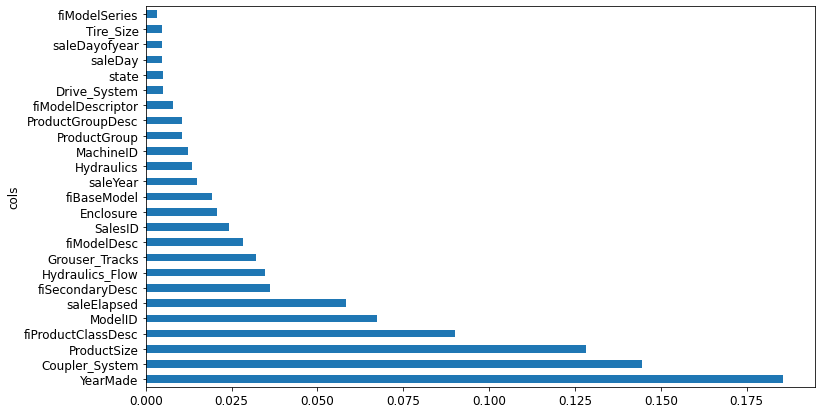

In [57]:
plot_fi(features_imp[:25])


The features with low feature importance scores can be removed without affecting the performance of the Random forest - this increases the processing time.

In [58]:
to_keep = features_imp[features_imp.imp > 0.005].cols

In [59]:
len(to_keep)


21

In [60]:
X_imp = X[to_keep]

In [61]:
valid_X_imp = valid_X[to_keep]

X_imp.shape, valid_X_imp.shape



In [62]:
m = rf(X_imp,y)

In [63]:
m_rmse(m,X_imp,y), m_rmse(m,valid_X_imp,valid_y)

(0.195962, 0.236006)

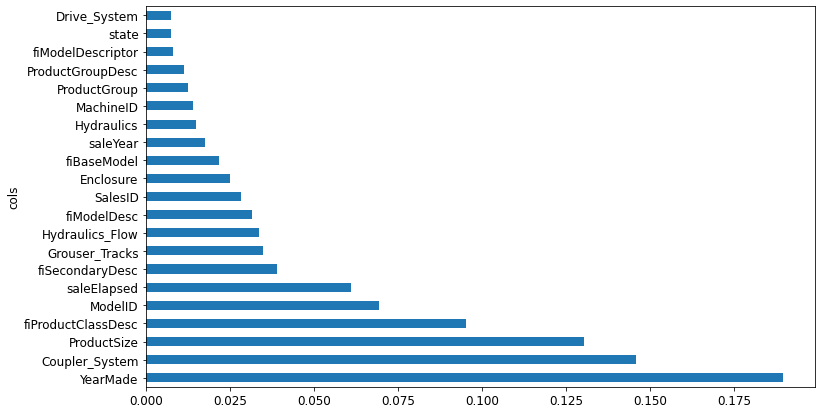

In [64]:
plot_fi(rf_feat_importance(m, X_imp));

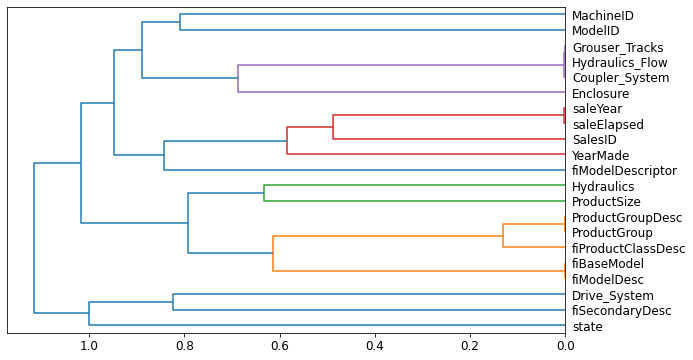

In [65]:
cluster_columns(X_imp)

Similarity between columns is studied to remove the redundant features - these features dont add to performance of the Random forest. the most related features are found by rank correlation. 

To get the redundant features, we take a simple fast Random forest model, get oob_score (R^2 in statistics) between 1.0(for perfect model) and 0.0(for random model)

In [66]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=15,max_samples=50000,max_features=0.5,n_jobs=-1,oob_score=True)
    m.fit(df,y)
    return m.oob_score_

In [67]:
get_oob(X_imp)

0.8764556130432918

We drop the features which seem redundant and check how badly it affects the oob score

In [ ]:
{c:get_oob(X_imp.drop(c,axis=1)) for c in ('saleYear', 'saleElapsed','ProductGroupDesc','ProductGroup',
    'fiModelDesc', 'fiBaseModel',
    'Hydraulics_Flow','Grouser_Tracks', 'Coupler_System')}

In [ ]:
to_drop = ['saleYear', 'ProductGroupDesc', 'fiBaseModel', 'Grouser_Tracks']
get_oob(X_imp.drop(to_drop, axis=1))

In [ ]:
X_final = X_imp.drop(to_drop,axis=1)
valid_X_final = valid_X_imp.drop(to_drop,axis=1)

In [ ]:
save_pickle('/kaggle/working/X_final.pkl', X_final)
save_pickle('/kaggle/working/valid_X_final.pkl', valid_X_final)

In [ ]:
m = rf(X_final,y)
m_rmse(m,X_final,y), m_rmse(m,valid_X_final, valid_y)

In [ ]:
p = valid_X_final['ProductSize'].value_counts(sort=False).plot.barh()
c = to.classes['ProductSize']
plt.yticks(range(len(c)),c)

In [ ]:
p = X_final['ProductSize'].value_counts(sort=False).plot.barh()
c = to.classes['ProductSize']
plt.yticks(range(len(c)),c)


In [ ]:
ax = valid_X_final['YearMade'].hist()

In [ ]:
X_final.loc[X_final['YearMade']<1900, 'YearMade'] = 1950
valid_X_final.loc[valid_X_final['YearMade']<1900, 'YearMade'] = 1950

In [ ]:
ax = valid_X_final['YearMade'].hist()

Another useful technique to find dependence of dependent variable on eachfeautre is the dependence plot. If all the other features are the same and only one feature in  a row is varied, how would it impact the dependent variab

In [ ]:
ax = X_final['YearMade'].hist()

In [ ]:
from sklearn.inspection import plot_partial_dependence
fig,ax = plt.subplots(figsize=(12, 4))
plot_partial_dependence(m, valid_X_final, ['YearMade','ProductSize'],
                        grid_resolution=20, ax=ax);

Dataleakage is a common problem found in datasets. It is a phenomenon where a model is given access to information which should not be available in real-world. Missing values often end up leaking data. for example, for a problem, where a model is to be developed to predict whether grant is going to given to a person or not, there was a feature which was blank for some cases and it turns out for all the blank cases, application was rejected. The university would fill this after the grant has been received.meaning this would not have been available at the time of application


some measures to guard against data leakage:
Check whether the accuracy of the model is too good to be true.
Look for important predictors that don't make sense in practice.
Look for partial dependence plot results that don't make sense in practice.

In [ ]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

from treeinterpreter import treeinterpreter
from waterfall_chart import plot as waterfall


In [ ]:
valid_X_final.head()


In [ ]:
row = valid_X_final.iloc[:5]

In [ ]:
prediction,bias,contributions = treeinterpreter.predict(m,row.values)

prediction - the prediction made for the row values
bias - the root of every tree which is by default the average of all dependent variables.

In [ ]:
prediction[0],bias[0]

the contribution is the change introduced by addition with every feature .

In [ ]:
waterfall(valid_X_final.columns, contributions[0], threshold=0.08, 
          rotation_value=45,formatting='{:,.3f}');

This kind of analysis is useful during model deployment. the reason for prediction could be well explained to the end user - contributes to explainability

Random forests are excellent for scenarious where data patterns repeat. But, they dont generalize to new data patterns. The trees predictions are averaged to get a prediction and this usually involves working with known data points.

In [ ]:
#example
np.random.seed(42)
x_lin = torch.linspace(0,20,steps=40)
y_lin= x_lin + torch.randn_like(x_lin)
plt.scatter(x_lin,y_lin)

In [ ]:
x_lin.shape

sklearn expects independent variable to be matrix of shape [m,n]. Not [m,]

In [ ]:
xs_lin = x_lin.unsqueeze(1)
x_lin.shape,xs_lin.shape

In [ ]:
m_lin = RandomForestRegressor().fit(xs_lin[:30],y_lin[:30])

In [ ]:
plt.scatter(x_lin, y_lin, 20)
plt.scatter(x_lin, m_lin.predict(xs_lin), color='red', alpha=0.5);

The last few prediction are way out of the range. Random forests are good at making predictions with known data. but, inthis condition, the first 30 samples were used and the max value know by the rf algo is 15.5. for anything greater than that, only it is predicted.


So, while working with random forests and trees, we need to make sure that the test data does not contain out of domain data. the training data and test data are of similar distributions.

In [ ]:
df_dom = pd.concat([X_final, valid_X_final])


In [ ]:
is_valid = np.array([0]*len(X_final) + [1]*len(valid_X_final))

m = rf(df_dom, is_valid)
rf_feat_importance(m, df_dom)[:6]

In [ ]:
for c in ('SalesID','saleElapsed','MachineID'):
    m = rf(X_final.drop(c,axis=1), y)
    print(c, m_rmse(m, valid_X_final.drop(c,axis=1), valid_y))

In [ ]:
time_vars= ['SalesID', 'MachineID']
X_final_time = X_final.drop(time_vars, axis=1)
valid_X_time = valid_X_final.drop(time_vars, axis=1)

m = rf(X_final_time, y)
m_rmse(m, valid_X_time, valid_y)

The usual approach is that we discard old data because it is usually not valid anymore . Example below:

In [ ]:
X['saleYear'].hist(
)

In [ ]:
filt = X['saleYear']>2004
X_filt = X_final_time[filt]

In [ ]:
y_filt = y[filt]

In [ ]:
m = rf(X_filt, y_filt)
m_rmse(m, X_filt, y_filt), m_rmse(m, valid_X_time, valid_y)

Sometimes instead of using the entire set , only a subset of data can generate better results as old data is outdated and doesnt fit well for validation data


Same operation can be done with neural networks , though it requires more computation resources.

In [ ]:
df_nn = pd.read_csv('/kaggle/input/bluebook-for-bulldozers/TrainAndValid.csv', low_memory=False)

In [ ]:
df_nn['ProductSize'] = df_nn['ProductSize'].astype('category')
df_nn['ProductSize'].cat.set_categories(sizes, ordered=True, inplace=True)

In [ ]:
df_nn[dep_var] = np.log(df_nn[dep_var])
df_nn = add_datepart(df_nn, 'saledate')

We can use the efforts made in Random Forests. Remove all the columns which were trimmed before. 


In [ ]:
df_nn_final = df_nn[list(X_final_time.columns) + [dep_var]]
     

The fastai library will split the features into continuous and categorical depending on max_card , it is never set above 10000. That is if there are more than 10000 categories, better to treat it as continuous

In [ ]:
cont_nn,cat_nn = cont_cat_split(df_nn_final, max_card=9000, dep_var=dep_var)

In [ ]:
cont_nn

In [ ]:
df_nn_final[cat_nn].nunique()

ModelID and fiModelDesc both have around 5000 levels and they seem similar. So,instead of having both, we could check if one can be removed. [as we might required 5000 column embedding matrix]

In [ ]:
X_filt2 = X_filt.drop('fiModelDescriptor', axis=1)
valid_X_time2 = valid_X_time.drop('fiModelDescriptor', axis=1)
m2 = rf(X_filt2, y_filt)
m_rmse(m2, X_filt2, y_filt), m_rmse(m2, valid_X_time2, valid_y)

In [ ]:
cat_nn.remove('fiModelDescriptor')

Randomforests dont care about normalization , they only care about the order of features. but, neural networks input 

In [ ]:
procs_nn = [Categorify, FillMissing, Normalize]

In [ ]:
to_nn = TabularPandas(df_nn_final, procs_nn, cat_nn, cont_nn,
                      splits=splits, y_names=dep_var)

Tabular data generally dont require large GPU RAM

In [ ]:
dls = to_nn.dataloaders(1024)
#it is a good idea to set min and max values.ie range for regression problems
y = to_nn.train.y
y.min(),y.max()


In [ ]:
learn = tabular_learner(dls,y_range=(8,12),layers=[500,250], n_out=1,loss_func=F.mse_loss)

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(5, 1e-2)
preds,targs = learn.get_preds()
r_mse(preds,targs)

In [ ]:
learn.save('nn')